In [1]:
import sys
sys.path.insert(0, '/Users/ahmedbegga/Desktop/TFG-Ahmed/SetXAI/')
import torch
import torch.nn as nn
import torch.nn.functional as F
from src.utils import *
from src.model import *
from data.MnistSet import *
from time import sleep
from tqdm import tqdm

### Preparamos los datos de entreno y test

In [2]:
batch_size = 32

In [3]:
train_loader = get_loader(
            MNISTSet(train=True, full=True), batch_size=batch_size, num_workers=4)

In [4]:
test_loader = get_loader(
            MNISTSet(train=False, full=True), batch_size=batch_size, num_workers=4)

In [5]:
from time import sleep
from tqdm import tqdm

In [6]:
set_channels = 2
set_size = 342
  
hidden_dim = 32
iters = 10
latent_dim = 16
lr = 0.001
n_epochs = 100
net = MaxEncoder(set_channels,latent_dim,hidden_dim)

In [7]:
net

MaxEncoder(
  (conv): Sequential(
    (0): Conv1d(2, 32, kernel_size=(1,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
  )
  (lin): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [8]:
optimizer = torch.optim.Adam([p for p in net.parameters() if p.requires_grad], lr=0.001)

In [9]:
#net = net.cuda()

In [10]:
net.train()
for epoch in range(n_epochs):
    with tqdm(train_loader, unit="batch") as tepoch:
        for i, sample in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")
            input, target_set, target_mask = map(lambda x: x, sample)
            optimizer.zero_grad()
            output = net(target_set,target_mask)
            loss = F.cross_entropy(output, input)
            acc = (output.max(dim=1)[1] == input).float().mean()
            loss.backward()
            optimizer.step()
            tepoch.set_postfix(loss=loss.item(), acc=100. * acc.item())

Epoch 99: 100%|███████████████████████████████████████████████| 1875/1875 [01:13<00:00, 25.53batch/s, acc=84.4, loss=0.265]


In [11]:
net.eval()
with tqdm(test_loader, unit="batch") as tepoch:
    for i, sample in enumerate(tepoch):
        tepoch.set_description(f"Epoch {1}")
        input, target_set, target_mask = map(lambda x: x, sample)
        output = net(target_set,target_mask)
        loss = F.cross_entropy(output, input)
        acc = (output.max(dim=1)[1] == input).float().mean()
        tepoch.set_postfix(loss=loss.item(), acc=100. * acc.item())

Epoch 1: 100%|██████████████████████████████████████████████████| 312/312 [00:08<00:00, 37.03batch/s, acc=100, loss=0.0594]


In [12]:
#torch.save(net.state_dict(),'model_max_encoder.pth')

In [9]:
model = torch.load('./MaxEncoder_model_mnist.pth' ,map_location=torch.device('cpu'))
miNet = MaxEncoder(set_channels,latent_dim,hidden_dim)

In [10]:
miNet.load_state_dict(torch.load('./MaxEncoder_model_mnist.pth' ,map_location=torch.device('cpu')))

<All keys matched successfully>

In [11]:
miNet

MaxEncoder(
  (conv): Sequential(
    (0): Conv1d(2, 32, kernel_size=(1,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
  )
  (lin): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [13]:
miNet = miNet
miNet.eval()
losses = []
accs = []
with tqdm(test_loader, unit="batch") as tepoch:
    for i, sample in enumerate(tepoch):
        tepoch.set_description(f"Epoch {0}")
        input, target_set, target_mask = map(lambda x: x, sample)
        output = miNet(target_set,target_mask)
        loss = F.cross_entropy(output, input)
        acc = (output.max(dim=1)[1] == input).float().mean()
        losses.append(loss.item())
        accs.append(acc.item())
        tepoch.set_postfix(loss=loss.item(), acc=100. * acc.item())
print('loss: {}, acc: {}'.format(round(sum(losses)/len(losses),2),round(sum(accs)/len(accs),2)))

Epoch 0: 100%|███████████████████████████| 312/312 [00:19<00:00, 16.02batch/s, acc=87.5, loss=0.227]

loss: 0.25, acc: 0.92


In [14]:
for name, param in miNet.named_parameters():
    print(name, param.size())

conv.0.weight torch.Size([32, 2, 1])
conv.0.bias torch.Size([32])
conv.2.weight torch.Size([32, 32, 1])
conv.2.bias torch.Size([32])
lin.0.weight torch.Size([32, 32])
lin.0.bias torch.Size([32])
lin.2.weight torch.Size([16, 32])
lin.2.bias torch.Size([16])
classifier.0.weight torch.Size([16, 16])
classifier.0.bias torch.Size([16])
classifier.2.weight torch.Size([10, 16])
classifier.2.bias torch.Size([10])


In [28]:
miNet

MaxEncoder(
  (conv): Sequential(
    (0): Conv1d(2, 32, kernel_size=(1,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
  )
  (lin): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [33]:
model.classifier = nn.Sequential(*[miNet.conv[i] for i in range(3)])
print(model.classifier)

Sequential(
  (0): Conv1d(2, 32, kernel_size=(1,), stride=(1,))
  (1): ReLU(inplace=True)
  (2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
)


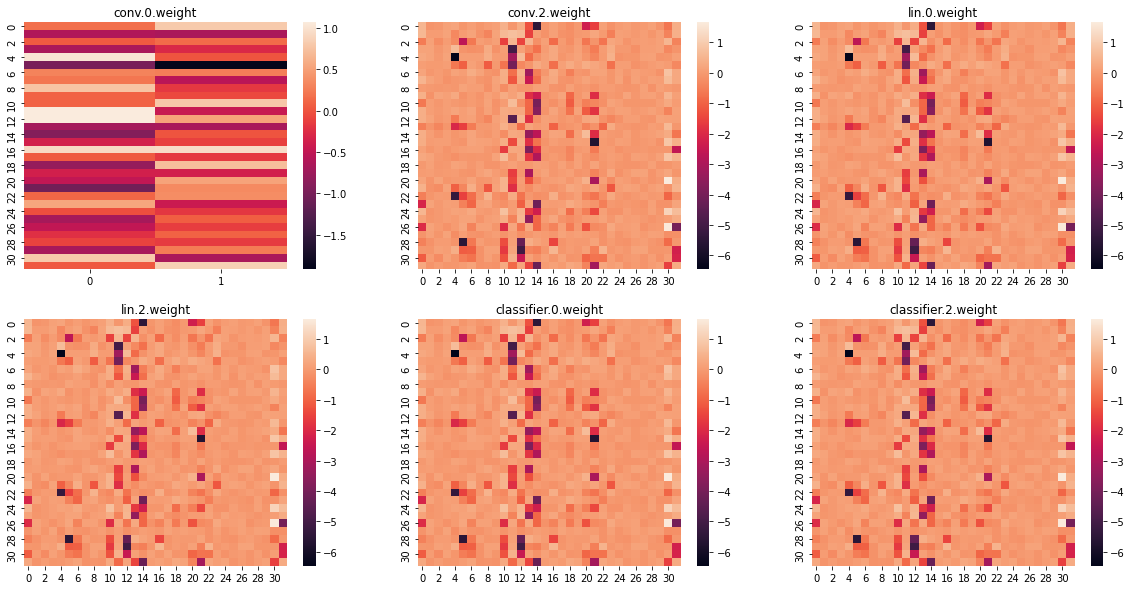

In [15]:
get_weight(miNet)

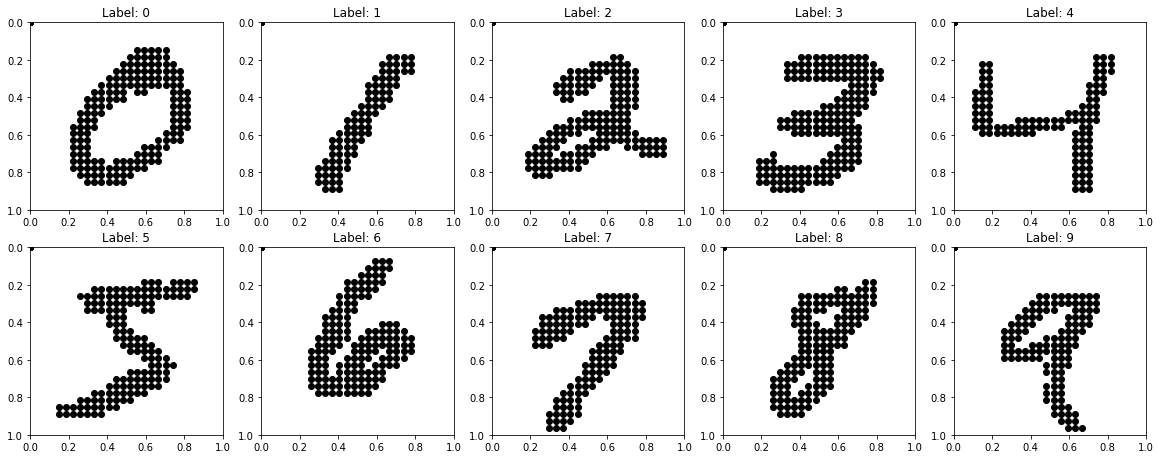

In [16]:
dataset_mnist_set = MNISTSet(full=True)
class_names =   [ 0 , 1 , 2,  3 , 4 , 5 , 6 , 7 ,  8 ,  9]
sampleSet = []
sampleMask = []
for i in range(len(class_names)):
    for j in range(len(dataset_mnist_set)):
        if i == dataset_mnist_set[j][0]:
            sampleSet.append(dataset_mnist_set[j][1])
            sampleMask.append(dataset_mnist_set[j][2])
            break
fig = plt.figure(figsize=(20, 20))

for i,set in enumerate(sampleSet):
    ax = fig.add_subplot(5, 5, i+1)
    x = set[1, :]
    y = set[0, :]
    plt.scatter(x, y,color = 'k')
    plt.axis([0, 1, 1, 0])
    plt.title('Label: {}'.format(i))

In [72]:
with torch.no_grad():
    for i in range(len(sampleSet)):
        pred = miNet(sampleSet[i].unsqueeze(0),sampleMask[i].unsqueeze(0))
        print("We obtained {}, and the expected is: {} with probaility".format(np.argmax(pred).item(),class_names[i]))

We obtained 0, and the expected is: 0 with probaility
We obtained 1, and the expected is: 1 with probaility
We obtained 2, and the expected is: 2 with probaility
We obtained 3, and the expected is: 3 with probaility
We obtained 4, and the expected is: 4 with probaility
We obtained 5, and the expected is: 5 with probaility
We obtained 6, and the expected is: 6 with probaility
We obtained 7, and the expected is: 7 with probaility
We obtained 8, and the expected is: 8 with probaility
We obtained 9, and the expected is: 9 with probaility


In [175]:
model1 = MaxEncoder(set_channels,latent_dim,hidden_dim)
model1 = torch.nn.Sequential(*(list(miNet.children())[:-2]))
print(model1)

Sequential(
  (0): Sequential(
    (0): Conv1d(2, 32, kernel_size=(1,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
  )
)


In [721]:
with torch.no_grad():
    pred = model1(sampleSet[0].unsqueeze(0))
print(pred.shape)

torch.Size([1, 32, 342])


torch.Size([1, 32])


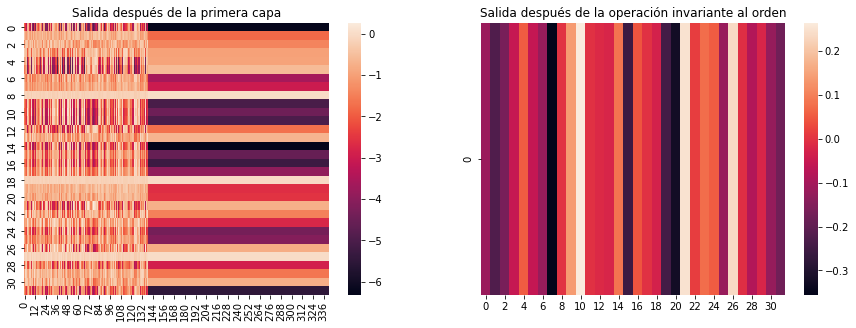

In [557]:
with torch.no_grad():
    fig, ax = plt.subplots(1, 1, figsize=(15,5))
    plt.subplot(1,2,1) 
    pred = model1(sampleSet[8].unsqueeze(0))
    feature_map = pred
    data = pred.squeeze(0).detach().numpy()
    sn.heatmap(data, annot=False, fmt='g')
    plt.title("Salida después de la primera capa")
    plt.subplot(1,2,2) 
    pred = pred.max(2)[0]
    max_map = pred
    print(max_map.shape)
    data = pred.detach().numpy()
    sn.heatmap(data, annot=False, fmt='g')
    plt.title("Salida después de la operación invariante al orden")
    plt.show()

In [701]:
def critical_points_MaxEncoder(model, sample):
    critical_points_y = []
    critical_points_x = []
    #Salida de la capa de convoluciones
    pred = model(sample.unsqueeze(0))
    features_map = pred.squeeze(0)
    #print(features_map.shape)
    #Aplicamos la operación invariante max
    xmax = features_map.max(axis=1)[0]
    #print(xmax.shape)
    xmaxargs = features_map.argmax(axis=1)
    #No nos quedamos con las coordenadas repetidas
    newxmaxargs = np.unique(xmaxargs)
    points = sample.numpy()
    '''
    critical = np.zeros(342)
    for f in range(32):
        for p in range(342):
            if features_map[f,p] == xmax[f]:
                critical[p] =critical[p]+1
    sorted_critical = np.sort(-critical)
    sorted_critical_args = -np.argsort(-critical)
    print(sorted_critical_args*-1)
    '''
    for k in range(len(newxmaxargs)):
        critical_points_y.append(points[0,newxmaxargs[k]])
        critical_points_x.append(points[1,newxmaxargs[k]])
    x = np.array(critical_points_x)
    y = np.array(critical_points_y)
    s = np.stack((y,x))
    return s 

In [702]:
crit = dataset_mnist_set[800][1]
s = critical_points_MaxEncoder(model1,crit)
s

array([[0.37037036, 0.6666667 , 0.37037036, 0.44444445, 0.7407407 ,
        0.22222222, 0.5185185 , 0.6296296 , 0.4814815 , 0.6666667 ,
        0.8148148 , 0.22222222, 0.5925926 , 0.9259259 , 0.22222222,
        0.9259259 , 0.        ],
       [0.7407407 , 0.37037036, 0.33333334, 0.7037037 , 0.6296296 ,
        0.7407407 , 0.2962963 , 0.33333334, 0.2962963 , 0.6296296 ,
        0.6296296 , 0.4814815 , 0.6666667 , 0.4814815 , 0.5185185 ,
        0.5925926 , 0.        ]], dtype=float32)

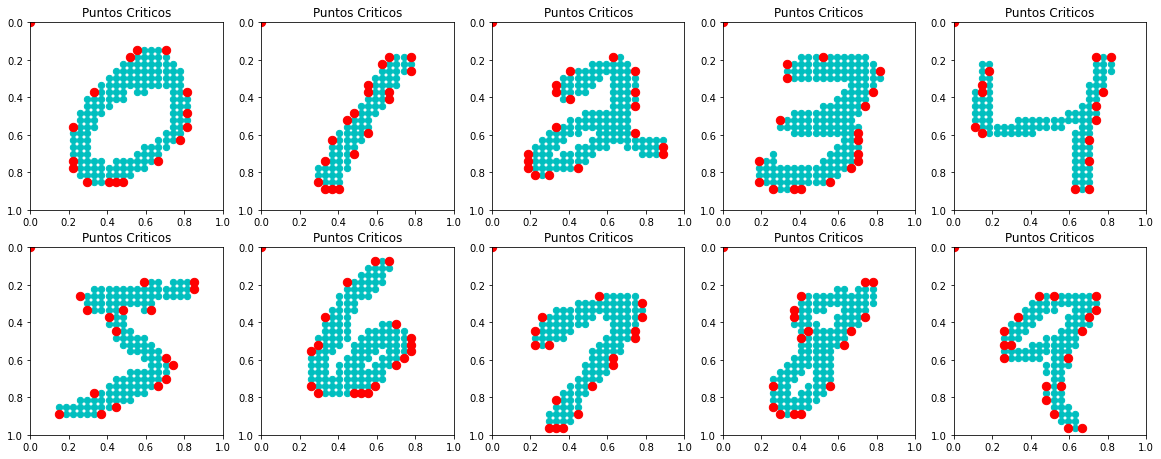

In [703]:
fig = plt.figure(figsize=(20, 20))
for i,set in enumerate(sampleSet):
    crit = critical_points_MaxEncoder(model1,set)
    ax = fig.add_subplot(5, 5, i+1)
    x = set[1, :]
    y = set[0, :]
    plt.scatter(x, y,color = 'c',s=40)
    x = crit[1, :]
    y = crit[0, :]
    plt.scatter(x, y,marker='o',color = 'r',s=70)
    plt.axis([0, 1, 1, 0])
    plt.title('Puntos Criticos')
plt.show()

In [708]:
dataset_mnist_set[3005][0]

3

In [718]:
crit = dataset_mnist_set[123][1]
s = critical_points_MaxEncoder(model1,crit)
st = torch.Tensor(s).unsqueeze(0)
print(st.shape)
muestraSintetica = torch.zeros(1,2,0)
muestraSintetica = torch.cat((st,muestraSintetica,),2)
mask_sintetica = torch.ones(1,st.size(2))
print(muestraSintetica.shape)
print(mask_sintetica.shape)

torch.Size([1, 2, 16])
torch.Size([1, 2, 16])
torch.Size([1, 16])


tensor([[1.0000, 0.5926, 0.4815, 0.3704, 0.4444, 0.7407, 0.4444, 0.4444, 0.4074,
         0.7407, 0.2963, 0.3333, 1.0000, 0.3704, 1.0000, 0.0000],
        [0.2593, 0.6667, 0.7407, 0.8148, 0.7407, 0.3704, 0.1852, 0.7778, 0.4815,
         0.5185, 0.5185, 0.8148, 0.2222, 0.1852, 0.2963, 0.0000]])


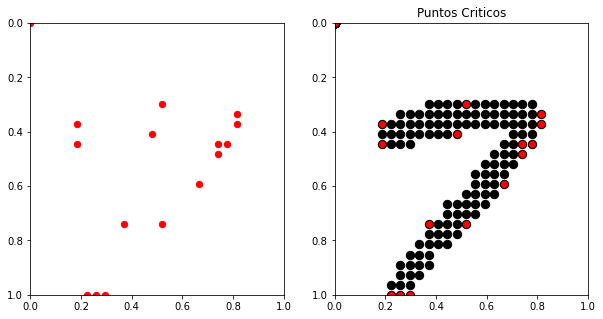

In [719]:
sam = muestraSintetica.squeeze(0)
print(sam)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2,1)
x1 = s[1, :]
y1 = s[0, :]
plt.scatter(x1, y1,c ='r',s=40)
#plt.scatter(x1, y1,marker='x',color ='r')
plt.axis([0, 1, 1, 0])
ax = fig.add_subplot(1, 2,2)
x = crit[1, :]
y = crit[0, :]
plt.scatter(x, y,marker='o',color = 'k',s=70)
plt.axis([0, 1, 1, 0])
plt.title('Puntos Criticos')
plt.scatter(x1, y1,marker='o',color ='r')
plt.show()

In [711]:
with torch.no_grad():
    pred = miNet(muestraSintetica,mask_sintetica)
    print(muestraSintetica.shape)
    print(mask_sintetica.shape)
    print("We obtained {}, and the expected is: {}".format(np.argmax(pred).item(),3))
    predReal= miNet(crit.unsqueeze(0),dataset_mnist_set[3005][1])
    print(pred)
    print(predReal)

torch.Size([1, 2, 19])
torch.Size([1, 19])
We obtained 3, and the expected is: 3
tensor([[ -4.4870,  -7.0404,  -4.2966,   8.4469, -12.1198,  -1.2992, -12.4668,
          -5.4116,  -0.3192,  -3.2575]])
tensor([[ -4.4870,  -7.0404,  -4.2966,   8.4469, -12.1198,  -1.2992, -12.4668,
          -5.4116,  -0.3192,  -3.2575]])


In [722]:
with torch.no_grad():
    for i in range(len(sampleSet)):
        #Preparacion de la muestra sintetica
        crit = sampleSet[i]
        s = critical_points_MaxEncoder(model1,crit)
        st = torch.Tensor(s).unsqueeze(0)
        muestraSintetica = torch.zeros(1,2,0)
        muestraSintetica = torch.cat((st,muestraSintetica,),2)
        mask_sintetica = torch.ones(1,st.size(2))
        #Prediccion de la red con la muestra
        pred = miNet(muestraSintetica,mask_sintetica)
        predReal= miNet(crit.unsqueeze(0),sampleMask[i].unsqueeze(0))
        print()
        print("We obtained {}, and the expected is: {}, with this trust {}, vs the real one: {}".format(np.argmax(pred).item(), class_names[i],round(pred.max().item(),2),round(predReal.max().item(),2)))
        


We obtained 0, and the expected is: 0, with this trust 5.43, vs the real one: 5.43

We obtained 1, and the expected is: 1, with this trust 6.19, vs the real one: 6.19

We obtained 2, and the expected is: 2, with this trust 13.56, vs the real one: 13.56

We obtained 3, and the expected is: 3, with this trust 6.52, vs the real one: 6.52

We obtained 4, and the expected is: 4, with this trust 10.25, vs the real one: 10.25

We obtained 5, and the expected is: 5, with this trust 10.95, vs the real one: 10.95

We obtained 6, and the expected is: 6, with this trust 7.26, vs the real one: 7.26

We obtained 7, and the expected is: 7, with this trust 7.08, vs the real one: 7.08

We obtained 8, and the expected is: 8, with this trust 5.18, vs the real one: 5.18

We obtained 9, and the expected is: 9, with this trust 5.48, vs the real one: 5.48


## Otro experimento

In [96]:
342 - 18

324

In [97]:
muestraSintetica = torch.zeros(1,2,325)
a  = torch.Tensor(x2).unsqueeze(0)
k  = torch.Tensor(y2).unsqueeze(0)
print(k.shape)
f = torch.cat((k,a),0).unsqueeze(0)
print(f.shape)
muestraSintetica = torch.cat((f,muestraSintetica,),2)
muestraSintetica.shape
mask_sintetica = torch.ones(1,342)
print(muestraSintetica.shape)
print(mask_sintetica.shape)

torch.Size([1, 12])
torch.Size([1, 2, 12])
torch.Size([1, 2, 337])
torch.Size([1, 342])


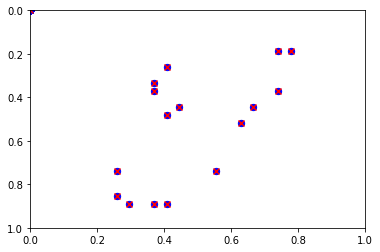

In [388]:
sam = muestraSintetica.squeeze(0)
x = sam[1, :]
y = sam[0, :]
plt.scatter(x, y,c ='b',s=40)
y1 = critical_points_ahmed_y
x1 = critical_points_ahmed_x
plt.scatter(x1, y1,marker='x',color ='r')
plt.axis([0, 1, 1, 0])
#pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
plt.show()

In [390]:
with torch.no_grad():
    pred = miNet(muestraSintetica,mask_sintetica)
    print(muestraSintetica.shape)
    print(mask_sintetica.shape)
    print("We obtained {}, and the expected is: {}".format(np.argmax(pred).item(),8))
    print(pred)

torch.Size([1, 2, 279])
torch.Size([1, 342])
We obtained 8, and the expected is: 8
tensor([[-10.5509,  -2.0976,  -1.5551,  -0.7148,  -4.0589,  -3.8527, -15.3150,
          -1.8981,   5.1760,  -4.1734]])


## Como afecta el eliminar los puntos críticos

In [103]:
import random

newSample = sampleSet[0].clone().detach().unsqueeze(0) #b
crit= -sorted_critical_args[:80]
print(len(crit))
for k in crit:
    #print(k)
    newSample[:,0,k] = random.uniform(0, 1)
    newSample[:,1,k] = random.uniform(0, 1)
#print(newSample)

80


In [105]:
sample2 = sampleSet[1].unsqueeze(0)

In [106]:
import random

newSample2 = sample2.clone().detach() #b
crit2= xmaxargs[:32]
print(len(crit2))
for k in crit:
    #print(k)
    newSample2[:,0,k] = random.uniform(0, 1)
    newSample2[:,1,k] = random.uniform(0, 1)
#print(newSample2)

32


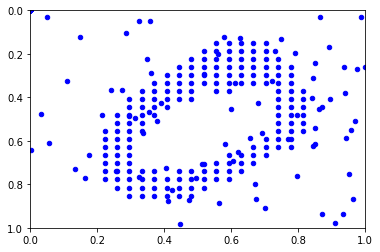

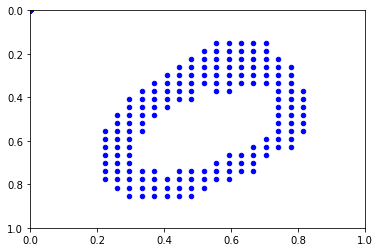

In [109]:
#En este trozo de código lo que hacemos es en las 80 primeras opciones criticas, ponemos valores aleatorios
n = newSample.squeeze(0)
x = n[1, :]
y = n[0, :]
plt.scatter(x, y,c ='b',s=20)
plt.axis([0, 1, 1, 0])
#pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
plt.show()
n = sampleSet[0].squeeze(0)
x = n[1, :]
y = n[0, :]
plt.scatter(x, y,c ='b',s=20)
plt.axis([0, 1, 1, 0])
#pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
plt.show()

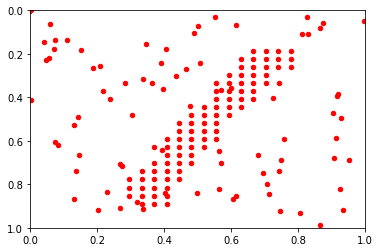

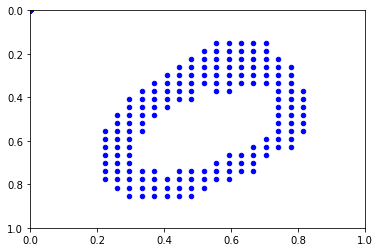

In [111]:
#En este trozo de código lo que hacemos es en las 80 primeras opciones criticas, ponemos valores aleatorios
n = newSample2.squeeze(0)
x = n[1, :]
y = n[0, :]
plt.scatter(x, y,c ='r',s=20)
plt.axis([0, 1, 1, 0])
#pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
plt.show()
n = sampleSet[0].squeeze(0)
x = n[1, :]
y = n[0, :]
plt.scatter(x, y,c ='b',s=20)
plt.axis([0, 1, 1, 0])
#pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
plt.show()

In [113]:
with torch.no_grad():
    pred = miNet(newSample,mask_sintetica)
    print(muestraSintetica.shape)
    print(mask_sintetica.shape)
    print("We obtained {}, and the expected is: {}".format(np.argmax(pred).item(),0))

torch.Size([1, 2, 337])
torch.Size([1, 342])
We obtained 2, and the expected is: 0


In [115]:
with torch.no_grad():
    pred = miNet(newSample2,mask_sintetica)
    print(muestraSintetica.shape)
    print(mask_sintetica.shape)
    print("We obtained {}, and the expected is: {}".format(np.argmax(pred).item(),1))
    print(pred)

torch.Size([1, 2, 337])
torch.Size([1, 342])
We obtained 8, and the expected is: 1
tensor([[ -1.7677,  -5.3852,  -0.2804,  -5.9320,  -3.0321,  -7.9872,  -5.8508,
         -10.8778,  -0.2153,  -1.9246]])


## Comprobación de que funciona a la inversa, con los puntos menos informativos

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.